In [4]:
from matplotlib import pyplot as plt
import xarray as xr
import numpy as np
import dask
from dask.diagnostics import progress
from tqdm.autonotebook import tqdm 
import intake
import fsspec
import seaborn as sns
import math
import cartopy.crs as ccrs
import cartopy.feature as cf

%matplotlib inline
%config InlineBackend.figure_format = 'retina' 

<ipython-input-4-aa8d9df31bdc>:6: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [12]:
def get_lat_name(ds):
    for lat_name in ['lat', 'latitude']:
        if lat_name in ds.coords:
            return lat_name
    raise RuntimeError("Couldn't find a latitude coordinate")

def global_mean(ds):
    lat = ds[get_lat_name(ds)]
    weight = np.cos(np.deg2rad(lat))
    weight /= weight.mean()
    other_dims = set(ds.dims) - {'time'}
    return (ds * weight).mean(other_dims)

def alaska_mean(ds):
    lat_slice = ds.sel(lat=slice(60,71))
    ak_slice = lat_slice.sel(lon=slice(193,219))
    lat = ak_slice[get_lat_name(ds)]
    weight = np.cos(np.deg2rad(lat))
    weight /= weight.mean()
    other_dims = set(ak_slice.dims) - {'time'}
    return (ak_slice * weight).mean(other_dims)

def arctic_mean(ds):
    lat_slice = ds.sel(lat=slice(60,90))
    lat = lat_slice[get_lat_name(ds)]
    weight = np.cos(np.deg2rad(lat))
    weight /= weight.mean()
    other_dims = set(lat_slice.dims) - {'time'}
    return (lat_slice * weight).mean(other_dims)

In [6]:
def load_all_models(model_name):
    tas_anomaly_hist = xr.open_dataset('/nobackup/users/lulur/tas-anomaly_'+model_name+'_historical.nc')
    tas_anomaly_ssp126 = xr.open_dataset('/nobackup/users/lulur/tas-anomaly_'+model_name+'_ssp126.nc')
    tas_anomaly_ssp245 = xr.open_dataset('/nobackup/users/lulur/tas-anomaly_'+model_name+'_ssp245.nc')
    tas_anomaly_ssp370 = xr.open_dataset('/nobackup/users/lulur/tas-anomaly_'+model_name+'_ssp370.nc')
    tas_anomaly_ssp585 = xr.open_dataset('/nobackup/users/lulur/tas-anomaly_'+model_name+'_ssp585.nc')
    tas_anomalies = [tas_anomaly_hist,tas_anomaly_ssp126,tas_anomaly_ssp245,tas_anomaly_ssp370,tas_anomaly_ssp585]
    return tas_anomalies

In [8]:
BCC_tas_anomalies = load_all_models('BCC-CSM2-MR')
#WACCM_tas_anomalies = load_all_models('CESM2-WACCM')
ACCESS_CM2_tas_anomalies = load_all_models('ACCESS-CM2') #this one works but doesn't have ssp370

/home/lulur/.conda/envs/cicoes39/lib/python3.9/site-packages/xarray/coding/times.py:527: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/lulur/.conda/envs/cicoes39/lib/python3.9/site-packages/numpy/core/_asarray.py:102: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


In [13]:
gmsts = []
models = ['historical','ssp126','ssp245','ssp370','ssp585',]
for m in ACCESS_CM2_tas_anomalies:
    gmst = global_mean(m)
    gmsts.append(gmst)
    
akmsts = []
models = ['historical','ssp126','ssp245','ssp370','ssp585',]
for m in ACCESS_CM2_tas_anomalies:
    akmst = alaska_mean(m)
    akmsts.append(akmst)

arcmsts = []
models = ['historical','ssp126','ssp245','ssp370','ssp585',]
for m in ACCESS_CM2_tas_anomalies:
    arcmst = arctic_mean(m)
    arcmsts.append(arcmst)

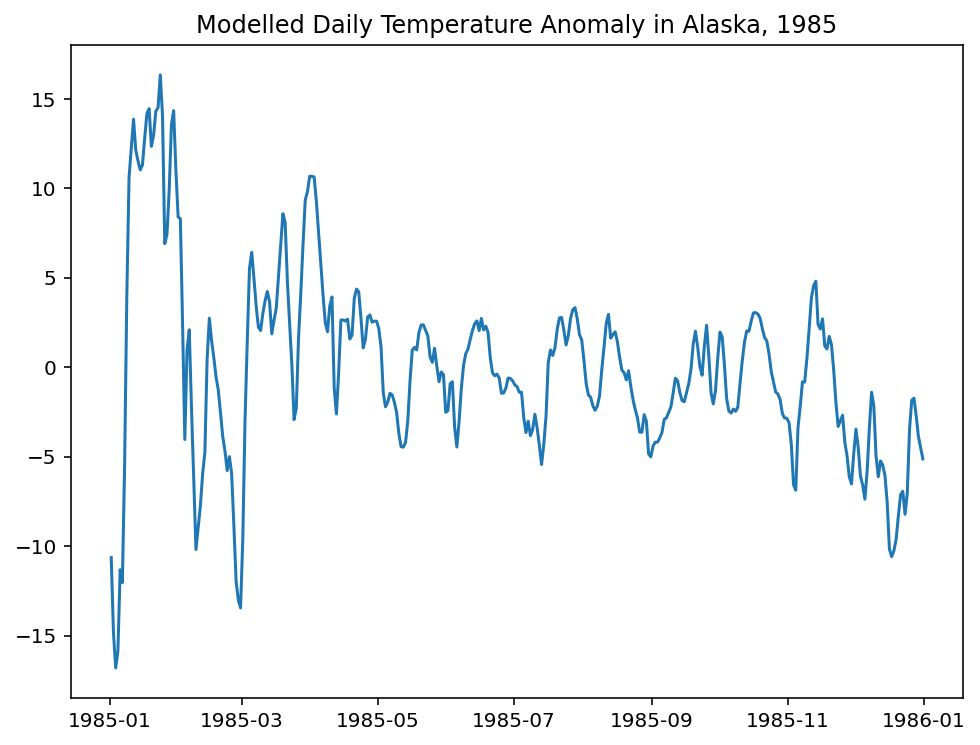

<Figure size 432x288 with 0 Axes>

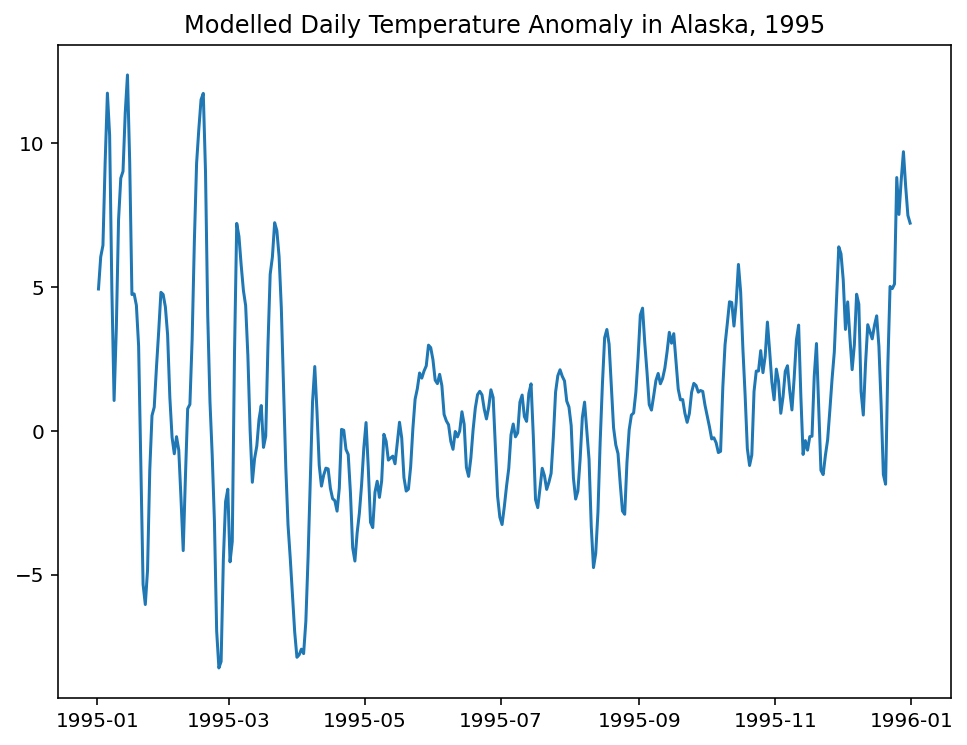

<Figure size 432x288 with 0 Axes>

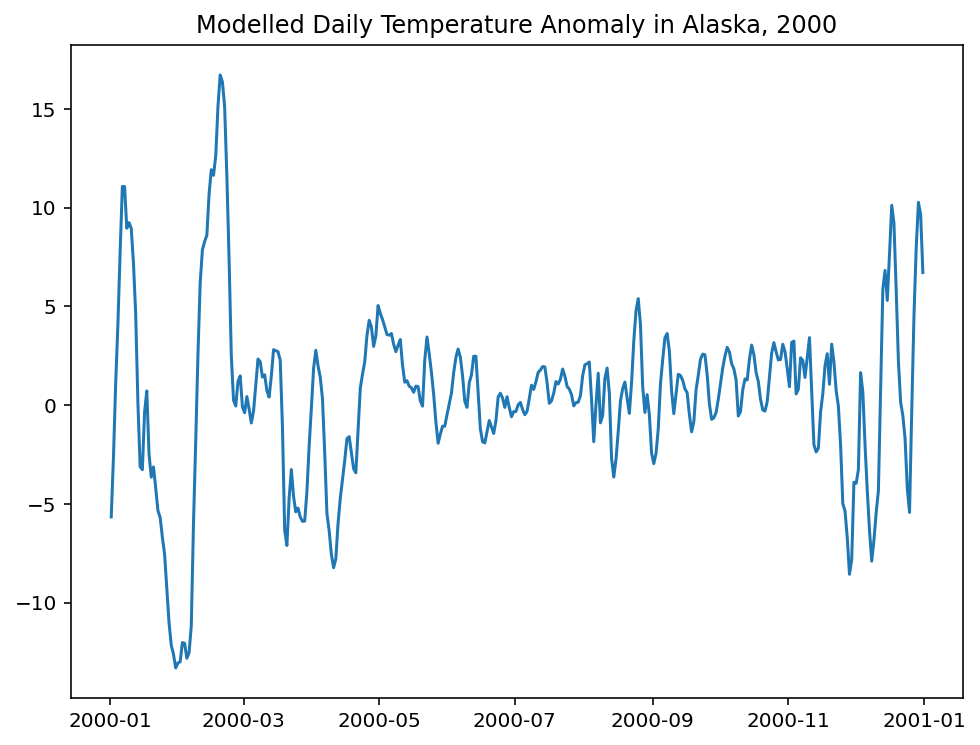

<Figure size 432x288 with 0 Axes>

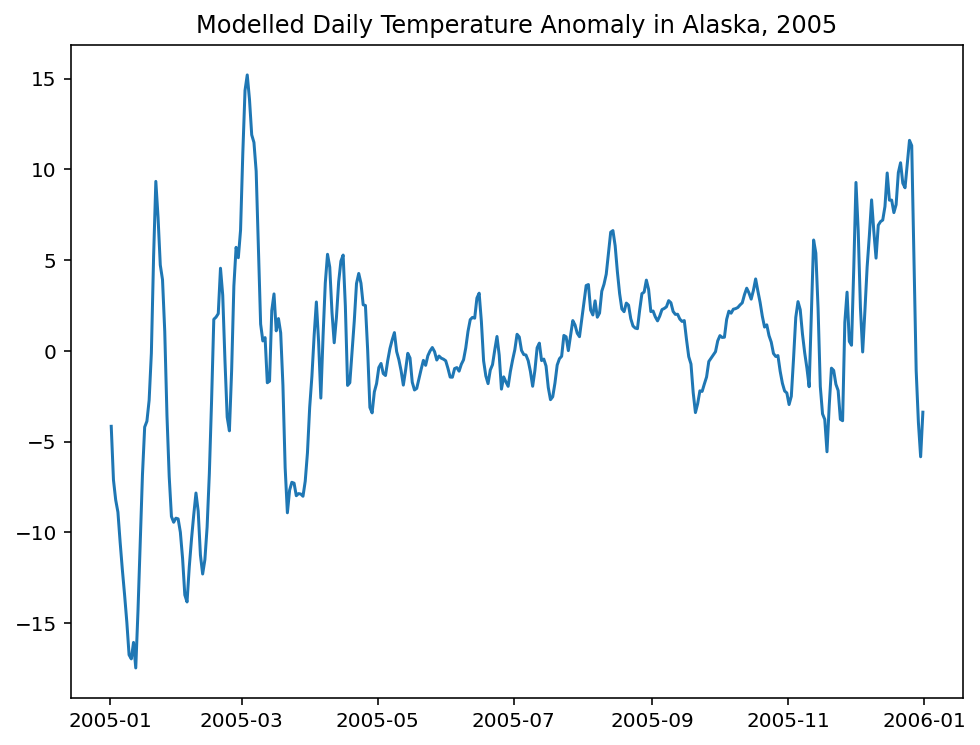

<Figure size 432x288 with 0 Axes>

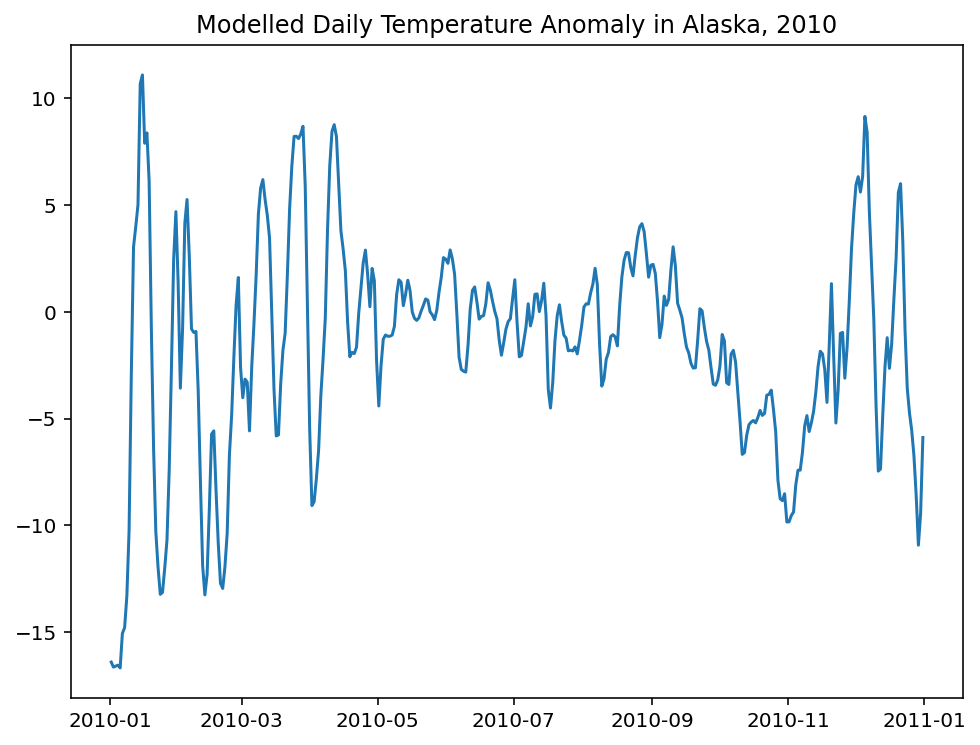

<Figure size 432x288 with 0 Axes>

In [11]:
def plot_daily_anomaly_by_year(year,msts):
    plt.figure(figsize=(8,6))
    if year < 2015:
        slicem = msts[0].sel(time=slice(str(year)+'-01-01', str(year)+'-12-31'))
        plt.plot(slicem['time'],slicem['tas'],label=models[0])
    else:
        for i in range(1,len(msts)):
            slicem = msts[i].sel(time=slice(str(year)+'-01-01', str(year)+'-12-31'))
            plt.plot(slicem['time'],slicem['tas'],label=models[i])
        #plt.xlim(19
    #plt.ylim(0)
    plt.title('Modelled Daily Temperature Anomaly in Alaska, '+str(year))
    #plt.legend()
    plt.show()
    plt.savefig('./figures/daily_anomalies/dailyanomaly_alaska_'+str(year)+'.png')

years = (2020,2030,2040,2050)
hist_years = (1985,1995,2000,2005,2010)
for yr in hist_years:
    plot_daily_anomaly_by_year(yr,akmsts)

In [ ]:
def plot_daily_anomaly_by_year(year,msts):
    plt.figure(figsize=(8,6))
    if year < 2015:
        slicem = msts[0].sel(time=slice(str(year)+'-01-01', str(year)+'-12-31'))
        plt.plot(slicem['time'],slicem['tas'],label=models[0])
    else:
        for i in range(1,len(msts)):
            slicem = msts[i].sel(time=slice(str(year)+'-01-01', str(year)+'-12-31'))
            plt.plot(slicem['time'],slicem['tas'],label=models[i])
        #plt.xlim(19
    #plt.ylim(0)
    plt.title('Modelled Daily Temperature Anomaly in the Arctic, '+str(year))
    #plt.legend()
    plt.show()
    plt.savefig('./figures/daily_anomalies/dailyanomaly_alaska_'+str(year)+'.png')

#years = (2020,2030,2040,2050)
hist_years = (1985,1995,2000,2005,2010)
for yr in hist_years:
    plot_daily_anomaly_by_year(yr,arcmsts)